# Построение моделей временных рядов

In [1]:
## импорт заивисимостей

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

## Исходные данные

In [2]:
data = pd.read_csv("data_series.csv")
data['t'] = data['t'].apply(str)
HTML(data.T.to_html(header = False))

t,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
y,10395,10631,10676,11323,13294,13105,12574,12880,13421,13346,11155,10944,11427,12011,11982,11380,11524,11998,12090,11816,12453,13110,12932,12334,12723,13802,13857,13304,13857


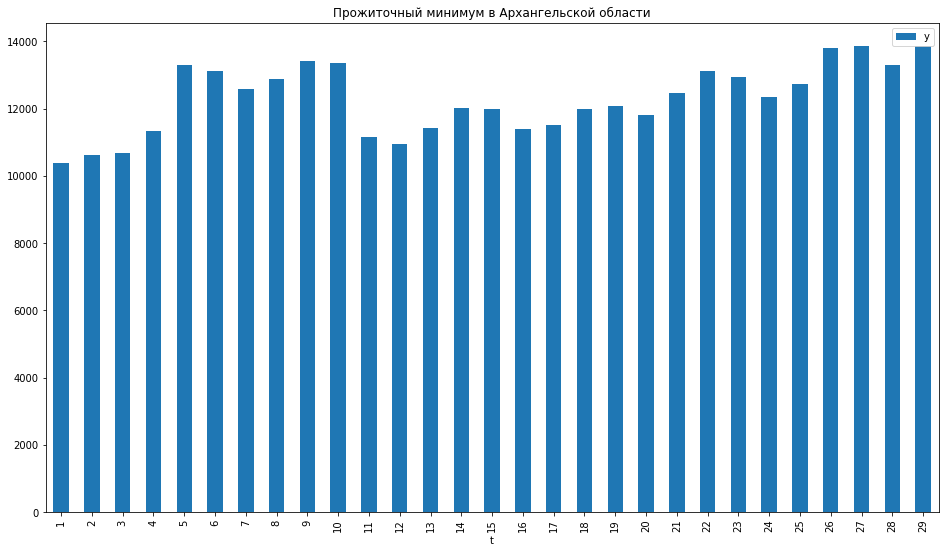

In [3]:
data.plot(x = 't', y = 'y', figsize=(16, 9), kind = "bar", title = "Прожиточный минимум в Архангельской области")

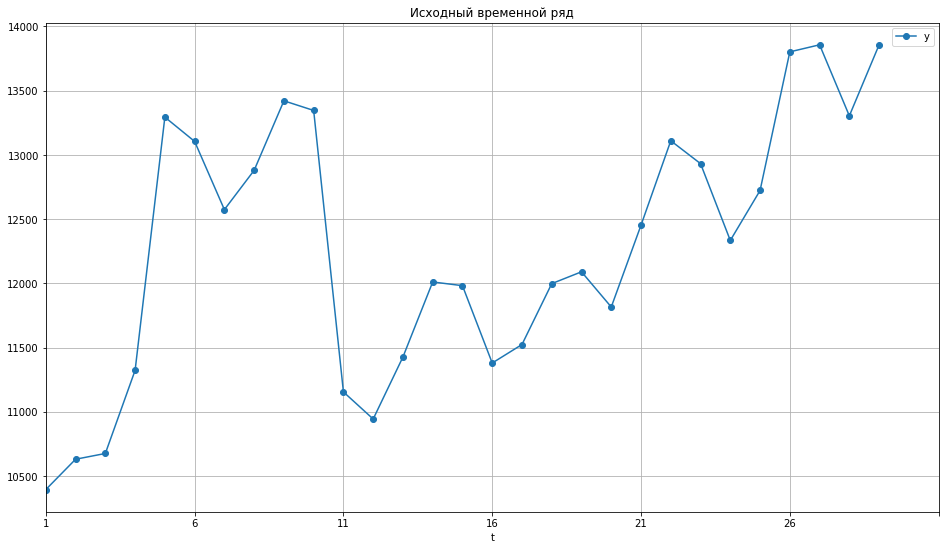

In [4]:
data.plot(x = 't', y = 'y', figsize=(16, 9), grid = True, marker='o',title = "Исходный временной ряд", xlim = (0,len(data)+1))

## Вспомогательные функции и переменные

### Количество шагов ($\tau$), на которые будет производится прогноз
Для всех моделей прогноз будет производится на 4 шага вперед

In [5]:
TAU = 4

### Функция определения коэффициентов a,b по МНК
Согласно методу наименьших квадратов, уравнение для точки пересечения линии линейной регрессии $а$ с осью $y$ имеет следующий вид:
### <center>$a = \overline{y} - b\overline{x}$,</center>
где
## <center>$b = \frac{\sum_{i=1}^{n} (x_i-\overline{x})(y_i-\overline{y})}{\sum_{i=1}^{n} (x_i-\overline{x})^2}$</center>

In [6]:
def segment_slope(d, size = 5):
    d['t'] = d['t'].apply(int)
    X, Y = d.iloc[:size, 0], d.iloc[:size, 1]
    X_mean, Y_mean = np.mean(X), np.mean(Y)
    n,d = 0,0
    for i in range(len(X)):
        n += (X[i] - X_mean)*(Y[i] - Y_mean)
        d += (X[i] - X_mean)**2
    b = n / d
    a = Y_mean - b*X_mean
    return a,b

### Функция линейной зависимости параметров a,b от переменной t
### <center>$y = a+bt$</center>
Используется для расчёта предыдущих тренд-сезонных значений в моделях Хольта-Уинтерса и Телла-Вейджа

In [7]:
linear = lambda a,b,t: a+b*t

### Функции расчёта предыдущих тренд-сезонных значений  для моделей Хольта-Уинтерса и Телла-Вейджа
#### Для модели Хольта-Уинтерса согласно формуле:
### <center>$f_{i} = 0,5(\frac{y_i}{\hat{y}_i}+\frac{y_{i+4}}{\hat{y}_{i+4}}) \quad i \in [0,4]$</center>
#### Для модели Телла-Вейджа согласно формуле:
### <center>$f_{i} = 0,5(y_i-\hat{y}_i+y_{i+4}-\hat{y}_{i+4}) \quad i \in [0,4]$</center>
#### $\hat{y}_i$ - значения, полученные с помощью функции линейной зависимости

In [8]:
SF_start_values = lambda y, yr: [0.5*(y[i]-yr[i]+y[i+4]-yr[i+4]) for i in range(4)]
HW_start_values = lambda y, yr: [0.5*(y[i]/yr[i]+y[i+4]/yr[i+4]) for i in range(4)]

### Функция расчёта коэффициента детерминации $R^2$
Коэффициент детерминации - это доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью зависимости, то есть объясняющими переменными. Коэффициент детерминации для модели с константой принимает значения от 0 до 1. Чем ближе значение коэффициента к 1, тем сильнее зависимость. При оценке регрессионных моделей это интерпретируется как соответствие модели данным. Для приемлемых моделей предполагается, что коэффициент детерминации должен быть хотя бы не меньше 50 % (в этом случае коэффициент множественной корреляции превышает по модулю 70 %). Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими (коэффициент корреляции превышает 90 %). Значение коэффициента детерминации 1 означает функциональную зависимость между переменными. В общем случае коэффициент детерминации может быть и отрицательным, это говорит о крайней неадекватности модели: простое среднее приближает лучше.
Коэффициент детерминации определяется по формуле:
## <center>$R^2 = 1- \frac{SS_{res}}{SS_{tot}}$,</center>
где:
### <center>$SS_{res} = \sum_{i=1}^{n} (y_i - \hat{y_{i}})^2 $,</center>
### <center>$SS_{tot} = \sum_{i=1}^{n} (y_i - \overline{y_{i}})^2 $</center>
$y$ - исходные показатели временного ряда,
$\hat{y}$ - расчётные показатели временного ряда

In [9]:
def r_squared(Y,YTH):
    Y_mean = np.mean(Y)
    SS_res = sum([(Y[i] - YTH[i])**2 for i in range(len(Y))])
    SS_tot = sum([(item - Y_mean)**2 for item in Y])
    coef = 1-(SS_res/SS_tot)
    return "{}%".format(round(coef*100,2))

### Функция расчёта критерия Дарбина-Уотсона
Статистическая проверка наличия (отсутствия) автокорреляции в ряде остатков чаще всего осуществляется с помощью критерия Дарбина — Уотсона. Для этого строим эмпирическую (расчетную) статистику Дарбина — Уотсона (d-статистику), которая рассчитывается по формуле:
## <center>$d = \frac{\sum_{i=2}^{n} (e_i-e_{i-1})^2}{\sum_{i=1}^{n} {e_i}^2}$,</center>
где $e$ - ряд остатков. Значение полученной d-статистики сравнивается с границами интервала критических значений

In [10]:
darbin_watson = lambda e: {'value' : round(sum([(e[i] - e[i-1])**2 for i in range(1,len(e))])/sum([e[i]**2 for i in range(len(e))]),2),
                           'df': len(e)-1 }

### Функция расчёта R/S критерия
Для проверки соответствия распределения ряда остатков нормальному закону чаще всего применяют так называемый R/S-критерий:
### <center>$R/S = \frac{e_{max}-e_{min}}{S_e}$,</center>
Здесь $e$ - ряд остатков, $e_{max}$ и $e_{min}$ максимальные и минимальные значения уровней ряда остатков, $S_e$ — стандартное отклонение ряда остатков от своего среднего.
### <center>$S_e = \sqrt{\frac{\sum_{i=1}^{n} (e_i-\overline{e})^2}{n-1}}$</center>
Критические границы отношения R/S заданы таблично. Гипотеза о соответствии распределения ряда остатков нормальному закону принимается на выбранном уровне значимости а при условии, что эмпирическое (расчетное) значение R/S-критерия окажется внутри критических границ для данного уровня значимости.

In [11]:
rs_crit = lambda e: round((max(e)-min(e))/np.std(e, ddof = 1),2)

### Функция расчёта t-критерия Стьюдента
Для проверки гипотезы о равенстве математического ожидания уровней ряда остатков нулю, т.е о том, что среднее значение ряда остатков статистически незначимо отличается от нуля, строится эмпирическая (расчетная) t-статистика:
## <center>$t_{эмпир} = \frac{|\overline{e}-0|\sqrt{n}}{S_e}$</center>
где $e$ - ряд остатков. Проверяемую гипотезу отклоняем на уровне значимости $\alpha$ если $t_{эмпир} > t_{\alpha,v}$, где $t_{\alpha,v}$ — критерий распределения Стьюдента, соответствующий доверительной вероятности $p = (1-\alpha)$ и $v = (n-l)$ степеням свободы. В случае противоположного знака неравенства нулевая гипотеза не отклоняется.

In [64]:
student = lambda e: {'value' : round(abs(np.mean(e)-0)*np.sqrt(len(e))/(np.std(e, ddof = 1)),3), 'df' : len(e)-1}

### Функция расчёта критерия пиков
Проверка случайности колебаний уровней остаточной последовательности осуществляется критерием пиков (поворотных точек). Уровень последовательности $e_t$ считается максимумом, если он больше двух рядом стоящих уровней, т.е. $e_{t-1} < e_t > e_{t+1}$, и минимумом, если он меньше обоих соседних уровней, т.е. $e_{t-1} > e_t < e_{t+1}$. В обоих случаях $e_t$ считается поворотной точкой; общее число поворотных точек для остаточной последовательности $e_t$ обозначим через р. В случайной выборке математическое ожидание числа точек поворота р и дисперсия g выражаются формулами:
### <center>$p = \frac{2}{3}(n-2)$</center>
### <center>$g = \frac{16n-29}{90}$</center>
Критерием случайности с 5%-ным уровнем значимости, т.е. с доверительной вероятностью 95%, является выполнение неравенства:
### <center>$p > [\overline{p} - 1,96\sqrt{g}]$</center>
где квадратные скобки означают целую часть числа. Если это неравенство не выполняется, трендовая модель считается неадекватной.

In [13]:
def pick_crit(e):
    p = (2/3)*(len(e)-2)
    g = np.modf(p - 1.96*np.sqrt((16*len(e)-29)/90))
    return {
        'p:': p,
        'g:': g[1],
        'p > g:': p > g[1]
    }

## Построение модели Брауна
Модель Брауна определяется формулой:
### <center>$y_{th} = a_0+a_1\tau$</center>
### Определение параметра $\alpha$
Здесь используется оптимизированное значение параметра $\alpha$, процесс поиска оптимального значения параметра $\alpha$ описан [здесь](https://github.com/KnsRoo/DiscriminantAnalysis/blob/main/rgr/OptimizationParameters.ipynb). Параметр $\alpha$ используется для нахождения параметра $\beta$

In [14]:
alpha = 0.34160103

Нахождение параметра $\beta$ и начальных значений $a_0,a_1$ по методу МНК. 
Для корректировки значений $a_0,a_1$ используется параметр $\beta = 1 - \alpha$

In [15]:
beta = 1 - alpha
a0,a1 = segment_slope(data)
print(a0, a1)

9316.8 649.0


Производится расчёт $y_{th}$. Корректировка значений $a_0,a_1$ производится по формулам:
### <center>$a_{0(t)} = a_{0(t-1}+a_{1(t-1)}+(1-{\beta}^2)\varepsilon{t}$</center>
### <center>$a_{1(t)} = a_{1(t-1}+(1-{\beta})^2\varepsilon{t}$</center>
$y_{th}$ расчитывается по формуле:
### <center>$y_{th} = a_{0(t)}+a_{1(t)}$</center>
Расчёт ошибки аппроксимации производится по формуле:
### <center>$\overline{e} = \frac{|\overline{y}-\overline{\hat{y}}|}{\overline{y}}$,</center>
что равнозначно:
### <center>$e_t = \frac{|y_t-\hat{y}_t|}{y_t}$</center>

In [16]:
y = data.iloc[:, 1]
yth = []
e = []
yth.append(sum([a0,a1]))
e.append(y[0]-yth[0])
e_appr = []
print(yth, e)
for i in range(1,len(y)):
    a0 = a0 + a1 + (1- beta**2)*e[i-1]
    a1 = a1 + (1 - beta)**2*e[i-1]
    yi = sum([a0,a1])
    yth.append(yi)
    e.append(y[i]-yi)
    
for i in range(0,len(y)):
    e_appr.append(abs(e[i])/y[i])

[9965.8] [429.2000000000007]


### Заполнение таблицы

In [17]:
brown_model = data.copy()
brown_model['t'] = brown_model['t'].apply(str)
brown_model.insert(2, 'y*', yth)
brown_model.insert(3, 'e_appr', e_appr)
HTML(brown_model.T.to_html(header = False))

t,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
y,10395,10631,10676,11323,13294,13105,12574,12880,13421,13346,11155,10944,11427,12011,11982,11380,11524,11998,12090,11816,12453,13110,12932,12334,12723,13802,13857,13304,13857
y*,9965.8,10908,11417.8,11577.8,11983.9,13429.4,13911.1,13663.1,13637.5,13907.7,13916.7,12357.2,11396.7,11257.5,11615.9,11797.6,11486.6,11437.7,11750.4,11977.7,11902.2,12294.5,12932,13107.5,12754.5,12818.2,13571.9,13963,13742.4
e_appr,0.0412891,0.0260587,0.0694873,0.0225004,0.0985481,0.0247557,0.10634,0.0607977,0.0161334,0.0420851,0.247579,0.129128,0.00265296,0.0627355,0.0305531,0.036694,0.00324881,0.0467007,0.0280887,0.0136862,0.0442338,0.0622007,2.76708e-09,0.062712,0.00247812,0.0712782,0.0205751,0.049536,0.00827035


### Построение графика
В данном случае $y*$ - модель Брауна временного ряда, наложенная на $y$ - исходный врменной ряд

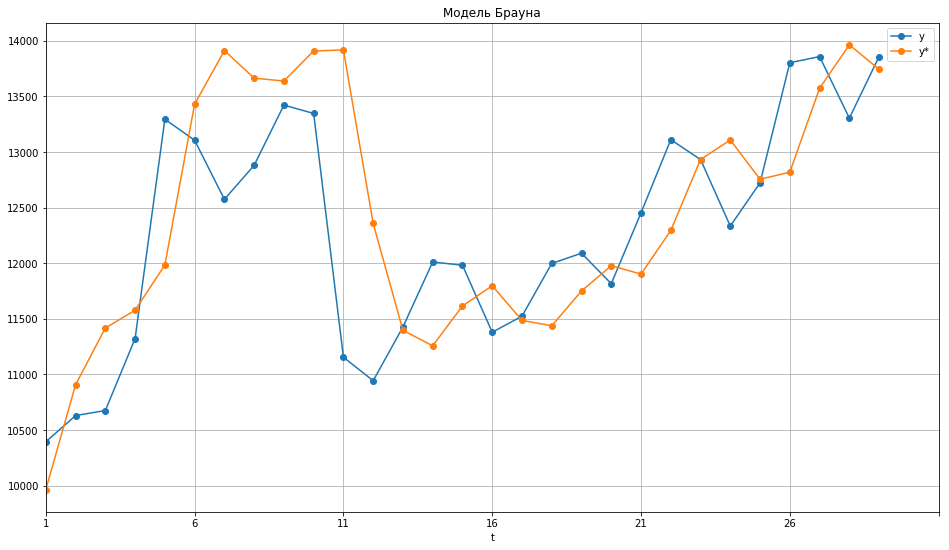

In [18]:
plot = brown_model.plot(x = 't', y = ['y','y*'], figsize=(16, 9), grid = True, marker='o',xlim = (0,len(data)+1), title = "Модель Брауна")

## Адекватность и точность модели
### Средняя ошибка аппроксимации

In [19]:
err = np.mean(e_appr)*100
print('{}%'.format(round(err,2)))

4.93%


### Коэффициент детерминации

In [20]:
value = r_squared(y,yth)
print(value)

34.37%


Коэффициент детерминации данной модели, ниже приемлемого (50%), из этого можно сделать вывод, что модель недостаточно точна

### Критерий Дарбина-Уотсона

In [21]:
value = darbin_watson(e)
print(value)

{'value': 1.23, 'df': 28}


Согласно [таблице критических значений критерия Дарбина-Уотсона](https://helpstat.ru/statistika-darbina-uotsona-dl-i-du/), полученное значение, при числе степеней свободы $df = 28$, и числе объясняющих переменных $k = 1$, лежит в интервале $d_L < 1,23 < d_V$, что соответствует ситуации неопределенности. Требуется провести дополнительные исследования. Проверим нулевую гипотезу о статистически незначимом отличии полученного коэффициента автокорреляции от нуля напрямую с помощью критерия Стьюдента:
### <center> $t_{эмпир} = \sqrt{\frac{d^2(n-2)}{1-d^2}},$ </center>
где $d$ - значения критерия Дарбина-Уотсона

In [65]:
d = value['value']
t = np.sqrt((d**2*(len(e)-2))/(1-d**2))
print(t)

2.1084738310548916


Согласно [таблице критических значений t-критерия Стьюдента](https://statpsy.ru/t-student/t-test-tablica/) , полученное значение $t_{эмпир}$, при числе степеней свободы $df = 28$ не превышает $3,674$, что соответствует доверительной вероятности $p = 0,001$. Из этого можно сделать вывод об отсутствии автокорреляции в ряде остатков. Модель можно назвать адекватной

### R/S критерий

In [22]:
value = rs_crit(e)
print(value)

4.96


Согласно [таблице критических значений R/S критерия](https://studme.org/142770/marketing/proverka_adekvatnosti_tochnosti_modeli), полученное значение, для длины временного ряда $l = 28$, значение $4,96$ не попадает в критический интервал, из этого можно сделать вывод, что гипотеза о соответствии распределения ряда остатков нормальному закону отвергается, модель нельзя назвать адекватной

### t-критерий Стьюдента

In [23]:
value = student(e)
print(value)

{'value': 0.936, 'df': 28}


Согласно [таблице критических значений t-критерия Стьюдента](https://statpsy.ru/t-student/t-test-tablica/) , полученное значение $t_{эмпир}$, при числе степеней свободы $df = 28$ не превышает $3,674$, что соответствует доверительной вероятности $p = 0,001$. Из чего можно сделать вывод, что средние значения в исследуемой выборке не отличаются от нормальных. Нулевая гипотеза не отвергается

### Критерий пиков

In [24]:
value = pick_crit(e)
print(value)

{'p:': 18.0, 'g:': 13.0, 'p > g:': True}


Согласно критерию пиков, модель можно назвать адекватной

## Прогноз по модели Брауна на 4 шага вперед
Прогноз по модели Брауна осуществляется по формуле:
### <center>$y_{th}(n+\tau) = a_{0(n)}+a_{1(n)}\tau$</center>

In [25]:
p = []
for i in range(1,TAU+1):
    yi = a0+a1*i
    p.append(yi)
print(p)

[13742.397730243523, 13895.114199852776, 14047.83066946203, 14200.547139071283]


### Заполнение таблицы спрогнозированными значениями

In [26]:
for index, item in enumerate(p):
    brown_model = brown_model.append({'t': 1+index+len(data['t']), 'pred': item}, ignore_index = True) 
brown_model.loc[len(data['t'])-1, 'pred'] = brown_model.loc[len(data['t'])-1,'y*']
brown_model['t'] = brown_model['t'].apply(str)
HTML(brown_model.T.to_html(header=False))

t,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30.0,31.0,32.0,33.0
y,10395,10631,10676,11323,13294,13105,12574,12880,13421,13346,11155,10944,11427,12011,11982,11380,11524,11998,12090,11816,12453,13110,12932,12334,12723,13802,13857,13304,13857,NaN,NaN,NaN,NaN
y*,9965.8,10908,11417.8,11577.8,11983.9,13429.4,13911.1,13663.1,13637.5,13907.7,13916.7,12357.2,11396.7,11257.5,11615.9,11797.6,11486.6,11437.7,11750.4,11977.7,11902.2,12294.5,12932,13107.5,12754.5,12818.2,13571.9,13963,13742.4,NaN,NaN,NaN,NaN
e_appr,0.0412891,0.0260587,0.0694873,0.0225004,0.0985481,0.0247557,0.10634,0.0607977,0.0161334,0.0420851,0.247579,0.129128,0.00265296,0.0627355,0.0305531,0.036694,0.00324881,0.0467007,0.0280887,0.0136862,0.0442338,0.0622007,2.76708e-09,0.062712,0.00247812,0.0712782,0.0205751,0.049536,0.00827035,NaN,NaN,NaN,NaN
pred,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13742.4,13742.4,13895.1,14047.8,14200.5


### Построение графика
Здесь $y$ - исходный временной ряд, $y*$ - модель, $pred$ - прогноз

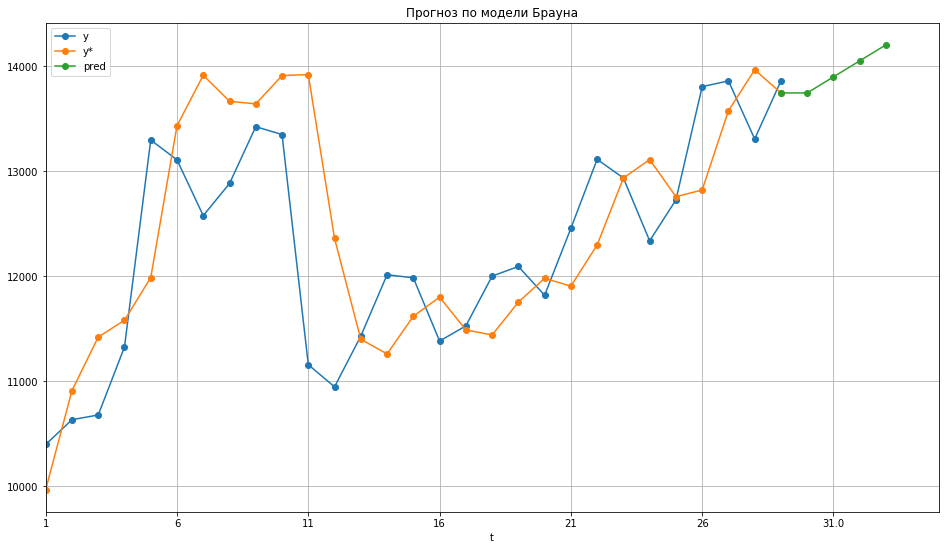

In [27]:
brown_model.plot(x = 't', y = ['y','y*', 'pred'], figsize=(16, 9), grid = True, marker='o', xlim = (0,len(brown_model)+1), title = "Прогноз по модели Брауна")

## Построение модели Хольта-Уинтерса
Модель Хольта-Уинтерса определяется формулой:
### <center>$y_{th} = (a_0+\tau a_1)F_i$</center>

### Определение параметров сглаживания $\lambda_1, \lambda_2, \lambda_3$
Здесь используются оптимизированные значения параметров $\lambda_1, \lambda_2, \lambda_3$, процесс поиска оптимальных значений параметров $\lambda_1, \lambda_2, \lambda_3$ описан [здесь](https://github.com/KnsRoo/DiscriminantAnalysis/blob/main/rgr/OptimizationParameters.ipynb).

In [28]:
l1, l2, l3 = 0.60694301, 1.01188937, 0.38280774

Нахождение начальных параметров $a_0,a_1$ проивзодится по методу МНК. Нахождение предыдущих сезонных трендовых значений производится согласно формулам, описанным выше

In [29]:
a0,a1 = segment_slope(data)
print(a0, a1)
y_r = [linear(a0,a1,i) for i in range(1,9)] 
y = data.iloc[:, 1]
f = HW_start_values(y,y_r)

9316.8 649.0


### Трендсезонные значения на предыдущий период

In [30]:
frame = pd.DataFrame.from_dict({'t': [i+1 for i in range(-len(f),0)], 'f': f})
HTML(frame.to_html(index = False))

t,f
-3,1.050678
-2,0.996759
-1,0.927522
0,0.919114


Производится расчёт $y_{th}$. Корректировка значений $a_0,a_1$ производится по формулам:
### <center>$a_{0(t)} = \lambda_1\frac{y_t}{F_{t-l}}+(1-\lambda_1)(a_{0(t-1)}+a_{1(t-1)})$</center>
### <center>$F_t = \lambda_2\frac{y_t}{a_{0(t)}}+(1-\lambda_2)F_{t-l}$</center>
### <center>$a_{1(t)} = \lambda_3(a_{0(t)}-a_{0(t-1)})$</center>
$y_t$ расчитывается по формуле:
### <center>$y_{th} = (a_{0(t)}+a_{1(t)})F_{t-l}$</center>
Расчёт ошибки аппроксимации производится по формуле:
### <center>$\overline{e} = \frac{|\overline{y}-\overline{\hat{y}}|}{\overline{y}}$,</center>
что равнозначно:
### <center>$e_t = \frac{|y_t-\hat{y}_t|}{y_t}$</center>

In [31]:
yth, e, e_appr = [], [], []
for i in range(len(y)):
    yi = (a0+a1)*f[i]
    yth.append(yi)
    e.append(y[i]-yi)
    e_appr.append(abs(e[i])/y[i])
    temp = a0
    a0 = l1*(y[i]/f[i])+(1-l1)*(a0+a1)
    f.append(l2*(y[i]/a0)+(1-l2)*f[i])
    a1 = l3*(a0 - temp)+(1-l3)*a1

### Заполнение таблицы

In [32]:
holt_winters_model = data.copy()
holt_winters_model['t'] = holt_winters_model['t'].apply(str)
holt_winters_model.insert(2, 'y*', yth)
holt_winters_model.insert(3, 'f', f[4:])
holt_winters_model.insert(4, 'e_appr', e_appr)
HTML(holt_winters_model.T.to_html(header = False))

t,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
y,10395,10631,10676,11323,13294,13105,12574,12880,13421,13346,11155,10944,11427,12011,11982,11380,11524,11998,12090,11816,12453,13110,12932,12334,12723,13802,13857,13304,13857
y*,10470.8,10520,10462.4,11150.1,13620.2,13507.2,12940.4,13039.9,14996.9,13486.1,12592.7,11402.8,11581.6,10978.6,10187.5,11860,12752.9,12278.6,10914.7,11154.9,12528.4,13581.6,12931.9,12233.4,12895.3,13622.2,13565.3,13121,13857.1
f,1.04764,1.00091,0.934963,0.92473,1.03751,0.988842,0.924248,0.920187,0.991194,0.98473,0.879154,0.905093,0.985889,1.01957,0.934799,0.890158,0.945757,1.01017,0.972378,0.910413,0.943486,0.995921,0.972379,0.913377,0.93843,1.00111,0.98059,0.9184,0.938427
e_appr,0.00729605,0.0104404,0.0200119,0.0152728,0.0245362,0.0306924,0.029143,0.0124134,0.117424,0.0104974,0.128886,0.0419221,0.0135293,0.0859518,0.14977,0.0421763,0.106636,0.0233908,0.0972115,0.0559535,0.00605183,0.0359728,4.27378e-06,0.00815853,0.0135455,0.0130293,0.0210537,0.0137524,7.67326e-06


### Построение графика
В данном случае  $𝑦∗$  - модель Хольта-Уинтерса временного ряда, наложенная на  $𝑦$  - исходный врменной ряд

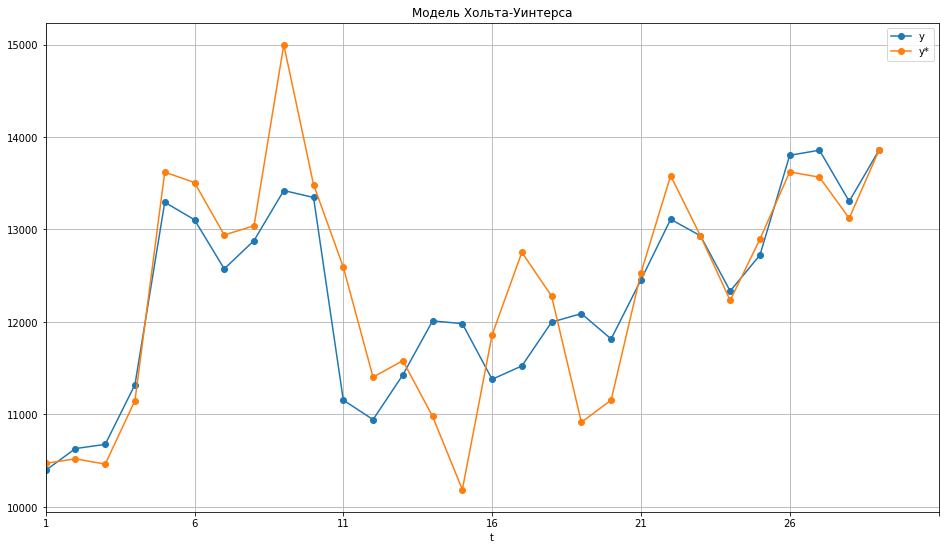

In [33]:
holt_winters_model.plot(x = 't', y = ['y','y*'], figsize=(16, 9), grid = True, marker='o', xlim = (0,len(data)+1), title = "Модель Хольта-Уинтерса")

## Адекватность и точность модели
### Средняя ошибка аппроксимации

In [34]:
err = np.mean(e_appr)*100
print('{}%'.format(round(err,2)))

3.91%


### Коэффициент детерминации

In [35]:
value = r_squared(y,yth)
print(value)

53.96%


Коэффициент детерминации данной модели, не ниже приемлемого (50%), из этого можно сделать вывод, что модель достаточно точна

### Критерий Дарбина-Уотсона

In [36]:
value = darbin_watson(e)
print(value)

{'value': 1.42, 'df': 28}


Согласно [таблице критических значений критерия Дарбина-Уотсона](https://helpstat.ru/statistika-darbina-uotsona-dl-i-du/), полученное значение, при числе степеней свободы $df = 28$, и числе объясняющих переменных $k = 2$, лежит в интервале $d_v < 1,42 < 2$, что означает отсутствие автокорелляции в ряде остатков. Из этого можно сделать вывод, что модель можно назвать адекватной

### R/S критерий

In [37]:
value = rs_crit(e)
print(value)

4.85


Согласно [таблице критических значений R/S критерия](https://studme.org/142770/marketing/proverka_adekvatnosti_tochnosti_modeli), полученное значение, для длины временного ряда $l = 28$, значение попадает в критический интервал $3,59 < 4,85 <4,89 $, что соответствует уровню доверительной вероятности $p = 0,1$ из этого можно сделать вывод, что гипотеза о соответствии распределения ряда остатков нормальному закону принимается, модель можно назвать адекватной

### t-критерий Стьюдента

In [38]:
value = student(e)
print(value)

{'value': 0.505, 'df': 28}


Согласно [таблице критических значений t-критерия Стьюдента](https://statpsy.ru/t-student/t-test-tablica/), полученное значение, при числе степеней свободы $df = 28$ не превышает $3,674$, что соответствует уровню доверительной вероятности $p = 0,001$. Из чего можно сделать вывод, что средние значения в исследуемой выборке не отличаются от нормальных. Нулевая гипотеза не отвергается

### Критерий пиков

In [39]:
value = pick_crit(e)
print(value)

{'p:': 18.0, 'g:': 13.0, 'p > g:': True}


Согласно критерию пиков, модель можно назвать адекватной

## Прогноз по модели Хольта-Уинтерса на 4 шага вперед
Прогноз по модели Хольта-Уинтерса осуществляется по формуле:
### <center>$y_{th}(n+\tau) = (a_{0(n)}+a_{1(n)}\tau)F_{t-l+\tau}$</center>

In [40]:
p = []
l = len(yth)
for i in range(1,TAU+1):
    yi = (a0+a1*i)*+f[i+len(yth)-1]
    p.append(yi)
print(p)

[15062.122608319625, 15027.238648383107, 14330.660559328537, 14905.213978270687]


### Заполнение таблицы спрогнозированными значениями

In [41]:
for index, item in enumerate(p):
    holt_winters_model = holt_winters_model.append({'t': 1+index+len(data['t']), 'pred': item}, ignore_index = True) 
holt_winters_model.loc[len(data['t'])-1, 'pred'] = holt_winters_model.loc[len(data['t'])-1,'y*']
holt_winters_model['t'] = holt_winters_model['t'].apply(str)
HTML(holt_winters_model.T.to_html(header=False))

t,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30.0,31.0,32.0,33.0
y,10395,10631,10676,11323,13294,13105,12574,12880,13421,13346,11155,10944,11427,12011,11982,11380,11524,11998,12090,11816,12453,13110,12932,12334,12723,13802,13857,13304,13857,NaN,NaN,NaN,NaN
y*,10470.8,10520,10462.4,11150.1,13620.2,13507.2,12940.4,13039.9,14996.9,13486.1,12592.7,11402.8,11581.6,10978.6,10187.5,11860,12752.9,12278.6,10914.7,11154.9,12528.4,13581.6,12931.9,12233.4,12895.3,13622.2,13565.3,13121,13857.1,NaN,NaN,NaN,NaN
f,1.04764,1.00091,0.934963,0.92473,1.03751,0.988842,0.924248,0.920187,0.991194,0.98473,0.879154,0.905093,0.985889,1.01957,0.934799,0.890158,0.945757,1.01017,0.972378,0.910413,0.943486,0.995921,0.972379,0.913377,0.93843,1.00111,0.98059,0.9184,0.938427,NaN,NaN,NaN,NaN
e_appr,0.00729605,0.0104404,0.0200119,0.0152728,0.0245362,0.0306924,0.029143,0.0124134,0.117424,0.0104974,0.128886,0.0419221,0.0135293,0.0859518,0.14977,0.0421763,0.106636,0.0233908,0.0972115,0.0559535,0.00605183,0.0359728,4.27378e-06,0.00815853,0.0135455,0.0130293,0.0210537,0.0137524,7.67326e-06,NaN,NaN,NaN,NaN
pred,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13857.1,15062.1,15027.2,14330.7,14905.2


### Построение графика
Здесь $y$ - исходный временной ряд, $y*$ - модель, $pred$ - прогноз

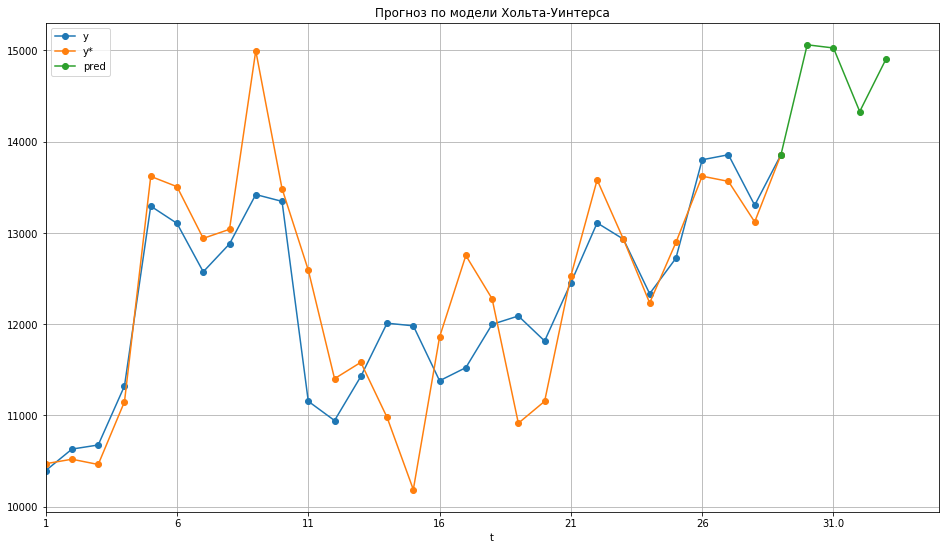

In [42]:
holt_winters_model.plot(x = 't', y = ['y','y*', 'pred'], figsize=(16, 9), grid = True, marker='o', xlim = (0,len(holt_winters_model)+1), title = "Прогноз по модели Хольта-Уинтерса")

## Построение модели Телла-Вейджа
Модель Хольта-Уинтерса определяется формулой:
### <center>$y_{th} = a_0+a_1+W_t$</center>

### Определение параметров сглаживания $\lambda_1, \lambda_2, \lambda_3$
Здесь используются оптимизированные значения параметров $\lambda_1, \lambda_2, \lambda_3$, процесс поиска оптимальных значений параметров $\lambda_1, \lambda_2, \lambda_3$ описан [здесь](https://github.com/KnsRoo/DiscriminantAnalysis/blob/main/rgr/OptimizationParameters.ipynb).

In [43]:
l1, l2, l3 = 0.73330596, 0.37075792, 1.4052209

Нахождение начальных параметров $a_0,a_1$ проивзодится по методу МНК. Нахождение предыдущих сезонных трендовых значений производится согласно формулам, описанным выше

In [44]:
a0,a1 = segment_slope(data)
print(a0, a1)
y_r = [linear(a0,a1,i) for i in range(1,9)] 
print(y_r)
y = data.iloc[:, 1]
w = SF_start_values(y,y_r)

9316.8 649.0
[9965.8, 10614.8, 11263.8, 11912.8, 12561.8, 13210.8, 13859.8, 14508.8]


### Трендсезонные значения на предыдущий период

In [45]:
frame = pd.DataFrame.from_dict({'t': [i+1 for i in range(-len(w),0)], 'w': w})
HTML(frame.to_html(index = False))

t,w
-3,580.7
-2,-44.8
-1,-936.8
0,-1109.3


Производится расчёт $y_{th}$. Корректировка значений $a_0,a_1$ производится по формулам:
### <center>$a_{0(t)} = \lambda_1(y_t-W_{t-l}+(1-\lambda)(a_{0(t-1)}+a_{1(t-1)})$</center>
### <center>$W_t = \lambda_3(y_t-a_{0(t)}+(1-\lambda_3)W_{t-l})$</center>
### <center>$a_{1(t)} = \lambda_2(a_{0(t)}-a_{0(t-1)+(1-\lambda_2)a_{1(t-1)}})$</center>
$y_t$ расчитывается по формуле:
### <center>$y_{th} = a_{0(t)}+a_{1(t)}+W_{t-l}$</center>
Расчёт ошибки аппроксимации производится по формуле:
### <center>$\overline{e} = \frac{|\overline{y}-\overline{\hat{y}}|}{\overline{y}}$,</center>
что равнозначно:
### <center>$e_t = \frac{|y_t-\hat{y}_t|}{y_t}$</center>

In [46]:
yth, e, e_appr = [], [], []
for i in range(len(y)):
    yi = a0+a1+w[i]
    yth.append(yi)
    e.append(y[i]-yi)
    e_appr.append(abs(e[i])/y[i])
    temp = a0
    a0 = l1*(y[i]-w[i])+(1-l1)*(a0+a1)
    a1 = l2*(a0-temp)+(1-l2)*a1
    w.append(l3*(y[i]-a0)+(1-l3)*w[i])    

### Заполнение таблицы

In [47]:
tella_weige_model = data.copy()
tella_weige_model['t'] = tella_weige_model['t'].apply(str)
tella_weige_model.insert(2, 'y*', yth)
tella_weige_model.insert(3, 'w', w[4:])
tella_weige_model.insert(4, 'e_appr', e_appr)
HTML(tella_weige_model.T.to_html(header = False))

t,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
y,10395,10631,10676,11323,13294,13105,12574,12880,13421,13346,11155,10944,11427,12011,11982,11380,11524,11998,12090,11816,12453,13110,12932,12334,12723,13802,13857,13304,13857
y*,10546.5,10417.7,10347.9,11171,13712,13599.4,12936.1,12881.9,14749.4,13346,12634.7,11132,11551.3,11041.5,10263,12236,12653.8,12007.6,10716.9,11302.1,12825.1,13563.6,12754,12104.4,12973.2,13690,13605.1,13122.4,13856.5
w,523.923,35.1317,-813.846,-1052.34,367.269,-150.138,-949.561,-1053.05,-130.57,-150.138,-1504.1,-1123.49,-177.165,213.192,-859.876,-1444.3,-600.557,209.582,-345.272,-1251.69,-740.004,39.579,-278.581,-1165.65,-833.763,81.5505,-184.186,-1097.59,-833.562
e_appr,0.0145743,0.0200626,0.030731,0.0134241,0.0314434,0.0377233,0.0288002,0.000147578,0.0989796,7.52091e-10,0.13265,0.0171756,0.0108805,0.0807168,0.143467,0.075222,0.0980352,0.000802779,0.113577,0.0434959,0.0298798,0.0346016,0.0137607,0.0186132,0.0196636,0.00811435,0.018177,0.0136513,3.87107e-05


### Построение графика
В данном случае  𝑦∗  - модель Телла-Вейджа временного ряда, наложенная на  𝑦  - исходный врменной ряд

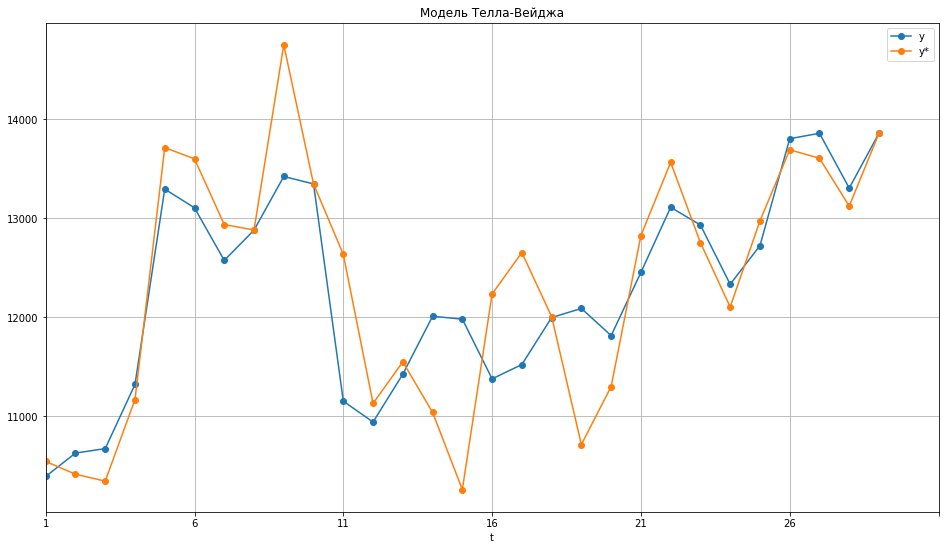

In [48]:
tella_weige_model.plot(x = 't', y = ['y','y*'], figsize=(16, 9), grid = True, marker='o', xlim = (0,len(data)+1), title = "Модель Телла-Вейджа")

## Адекватность и точность модели
### Средняя ошибка аппроксимации

In [49]:
err = np.mean(e_appr)*100
print('{}%'.format(round(err,2)))

3.96%


### Коэффициент детерминации

In [50]:
value = r_squared(y,yth)
print(value)

54.83%


Коэффициент детерминации данной модели, не ниже приемлемого (50%), из этого можно сделать вывод, что модель достаточно точна

### Критерий Дарбина-Уотсона

In [51]:
value = darbin_watson(e)
print(value)

{'value': 1.64, 'df': 28}


Согласно [таблице критических значений критерия Дарбина-Уотсона](https://helpstat.ru/statistika-darbina-uotsona-dl-i-du/), полученное значение, при числе степеней свободы $df = 28$, и числе объясняющих переменных $k = 2$, лежит в интервале $d_v < 1,64 < 2$, что означает отсутствие автокорелляции в ряде остатков. Из этого можно сделать вывод, что модель можно назвать адекватной

### R/S Критерий

In [52]:
value = rs_crit(e)
print(value)

4.63


Согласно [таблице критических значений R/S критерия](https://studme.org/142770/marketing/proverka_adekvatnosti_tochnosti_modeli), полученное значение, для длины временного ряда $l = 28$, значение попадает в критический интервал $3,47 < 4,63 <4,70 $, что соответствует уровню доверительной вероятности $p = 0,05$ из этого можно сделать вывод, что гипотеза о соответствии распределения ряда остатков нормальному закону принимается, модель можно назвать адекватной

### t-критерий Стьюдента

In [63]:
value = student(e)
print(value)

{'value': 0.376, 'df': 28}


Согласно [таблице критических значений t-критерия Стьюдента](https://statpsy.ru/t-student/t-test-tablica/), полученное значение, при числе степеней свободы $df = 28$ не превышает $3,674$, что соответствует уровню доверительной вероятности $p = 0,001$. Из чего можно сделать вывод, что средние значения в исследуемой выборке не отличаются от нормальных. Нулевая гипотеза не отвергается

### Критерий пиков

In [54]:
value = pick_crit(e)
print(value)

{'p:': 18.0, 'g:': 13.0, 'p > g:': True}


Согласно критерию пиков модель можно назвать адекватной

## Прогноз по модели Телла-Вейджа на 4 шага вперед
Прогноз по модели Телла-Вейджа осуществляется по формуле:
### <center>$y_{th}(n+\tau) = a_{0(n)}+a_{1(n)}\tau + W_{t-l+\tau}$</center>

In [55]:
p = []
l = len(yth)
for i in range(1,TAU+1):
    yi = (a0+a1*i)+w[i+len(yth)-1]
    p.append(yi)
print(p)

[15041.32417646874, 15044.74164803263, 14400.49122877062, 14933.674302694648]


### Заполнение таблицы спрогнозированными значениями

In [56]:
for index, item in enumerate(p):
    tella_weige_model = tella_weige_model.append({'t': 1+index+len(data['t']), 'pred': item}, ignore_index = True) 
tella_weige_model.loc[len(data['t'])-1, 'pred'] = tella_weige_model.loc[len(data['t'])-1,'y*']
tella_weige_model['t'] = tella_weige_model['t'].apply(str)
HTML(tella_weige_model.T.to_html(header=False))

t,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30.0,31.0,32.0,33.0
y,10395,10631,10676,11323,13294,13105,12574,12880,13421,13346,11155,10944,11427,12011,11982,11380,11524,11998,12090,11816,12453,13110,12932,12334,12723,13802,13857,13304,13857,NaN,NaN,NaN,NaN
y*,10546.5,10417.7,10347.9,11171,13712,13599.4,12936.1,12881.9,14749.4,13346,12634.7,11132,11551.3,11041.5,10263,12236,12653.8,12007.6,10716.9,11302.1,12825.1,13563.6,12754,12104.4,12973.2,13690,13605.1,13122.4,13856.5,NaN,NaN,NaN,NaN
w,523.923,35.1317,-813.846,-1052.34,367.269,-150.138,-949.561,-1053.05,-130.57,-150.138,-1504.1,-1123.49,-177.165,213.192,-859.876,-1444.3,-600.557,209.582,-345.272,-1251.69,-740.004,39.579,-278.581,-1165.65,-833.763,81.5505,-184.186,-1097.59,-833.562,NaN,NaN,NaN,NaN
e_appr,0.0145743,0.0200626,0.030731,0.0134241,0.0314434,0.0377233,0.0288002,0.000147578,0.0989796,7.52091e-10,0.13265,0.0171756,0.0108805,0.0807168,0.143467,0.075222,0.0980352,0.000802779,0.113577,0.0434959,0.0298798,0.0346016,0.0137607,0.0186132,0.0196636,0.00811435,0.018177,0.0136513,3.87107e-05,NaN,NaN,NaN,NaN
pred,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13856.5,15041.3,15044.7,14400.5,14933.7


### Построение графика

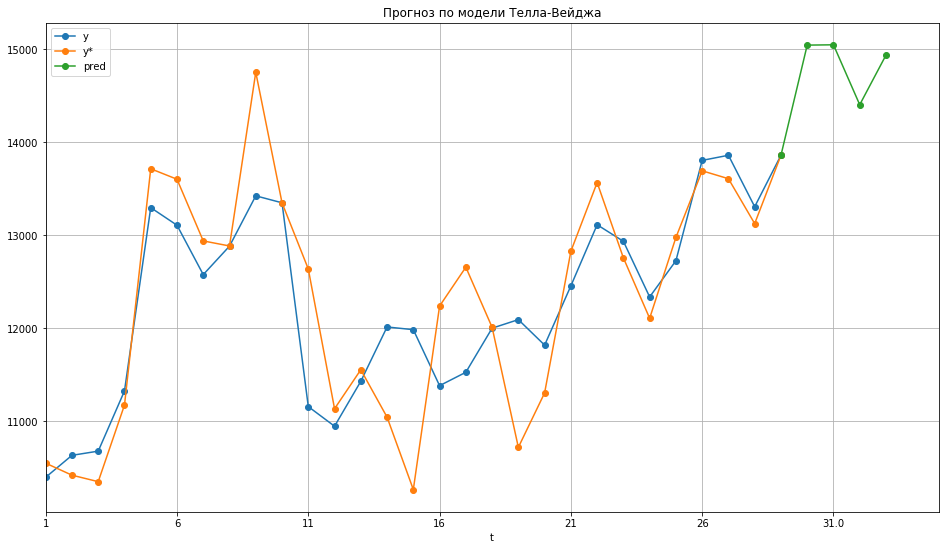

In [57]:
tella_weige_model.plot(x = 't', y = ['y','y*', 'pred'], figsize=(16, 9), grid = True, marker='o', xlim = (0,len(tella_weige_model)+1), title = "Прогноз по модели Телла-Вейджа")